In [19]:
import yt
from yt_experiments.tiled_grid import YTTiledArbitraryGrid, YTPyramid
import matplotlib.pyplot as plt
import numpy as np
import zarr

ds = yt.load_sample("DeeplyNestedZoom")

yt : [INFO     ] 2024-08-22 11:59:12,192 Sample dataset found in '/Users/chavlin/data/yt_data/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-08-22 11:59:12,380 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-08-22 11:59:12,381 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-08-22 11:59:12,381 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-22 11:59:12,382 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-08-22 11:59:12,382 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-08-22 11:59:12,382 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-08-22 11:59:12,382 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-08-22 11:59:12,383 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-08-22 11:59:12,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-08-22 11:59:12,383 Parameters: hubb

## creating a single tiled grid in memory

Start with a small one that can fit in memory. Not super useful: could just use a single arbitrary grid, but good for demo:

In [2]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (400, 400, 400), 100, ds=ds
)
vals = tag.to_array(("gas", "density"))
print(vals.shape)

Parsing Hierarchy : 100%|████████████████████████████████████████████████████████| 1825/1825 [00:00<00:00, 19902.25it/s]
yt : [INFO     ] 2024-08-22 10:58:55,328 Gathering a field list (this may take a moment.)


(400, 400, 400)


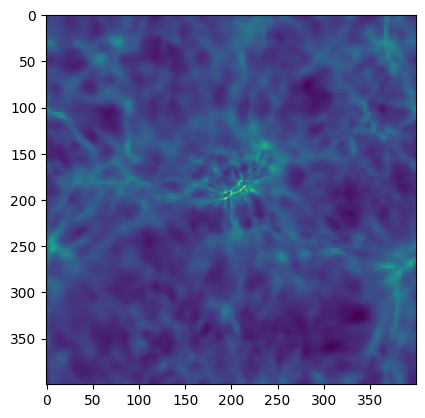

In [3]:
plt.imshow(np.log10(vals[:, :, 200]))

## A single tiled grid, larger-than memory on-disk zarr

In [4]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (1000, 1000, 1000), 100, ds=ds
)

In [7]:
zarr_store = zarr.group("tiled_grid.zarr")

In [8]:
dens = tag.to_zarr(
    ("gas", "density"),
    zarr_store,
)

In [9]:
dens.info

Name,/gas_density
Type,zarr.core.Array
Data type,float64
Shape,"(1000, 1000, 1000)"
Chunk shape,"(100, 100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8000000000 (7.5G)
No. bytes stored,521213917 (497.1M)


note directory layout

In [14]:
import os

os.listdir("tiled_grid.zarr/gas_density")[:10]

['4.7.0',
 '6.3.7',
 '6.9.9',
 '7.5.5',
 '5.1.2',
 '5.9.1',
 '7.7.8',
 '7.5.2',
 '5.1.5',
 '4.7.7']

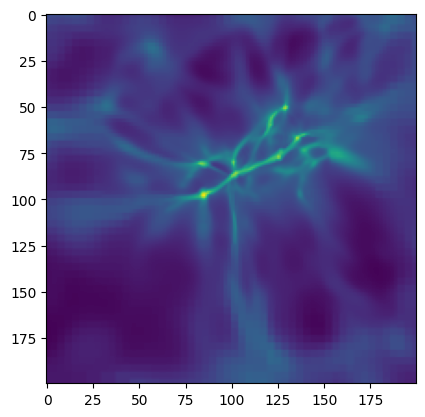

In [15]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(dens[400:600, 400:600, 500]))

## a pryamidal on-disk zarr

In [59]:
pyr = YTPyramid(ds.domain_left_edge, ds.domain_right_edge, (2**11,) * 3, 128, 5, ds=ds)

Decomposing [2048. 2048. 2048.] into 4096 chunks for level 0
Decomposing [1024. 1024. 1024.] into 512 chunks for level 1
Decomposing [512. 512. 512.] into 64 chunks for level 2
Decomposing [256. 256. 256.] into 8 chunks for level 3
Decomposing [128. 128. 128.] into 1 chunks for level 4


individual levels are comprised of `YTTiledArbitraryGrid` objects, accessible at:

In [30]:
pyr.levels[0]

In [31]:
pyr.levels[0].dims

array([2048., 2048., 2048.])

can write to on-disk zarr with

In [60]:
zarr_store = zarr.group("deeply_nested_pyramid.zarr")

going to leverage the callback operation functionality here to take the log of the density before writing

In [61]:
pyr.to_zarr(
    ("gas", "density"),
    zarr_store,
    zarr_name="density_log10",
    ops=[
        np.log10,
    ],
)

writing level 0
writing level 1
writing level 2
writing level 3
writing level 4


In [65]:
zarr_store["density_log10"].info

Name,/density_log10
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"0, 1, 2, 3, 4"


In [62]:
zarr_store["density_log10"]["0"].info

Name,/density_log10/0
Type,zarr.core.Array
Data type,float64
Shape,"(2048, 2048, 2048)"
Chunk shape,"(128, 128, 128)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,68719476736 (64.0G)
No. bytes stored,738091990 (703.9M)


In [63]:
zarr_store["density_log10"]["1"].info

Name,/density_log10/1
Type,zarr.core.Array
Data type,float64
Shape,"(1024, 1024, 1024)"
Chunk shape,"(128, 128, 128)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,8589934592 (8.0G)
No. bytes stored,176634390 (168.5M)


In [ ]:
zarr_store["density_log10"]["1"].info

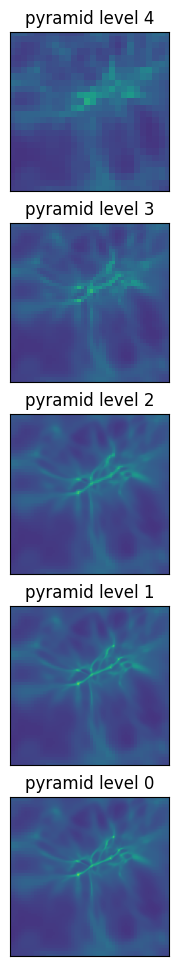

In [22]:
maxlevels = 5

f, axs = plt.subplots(ncols=1, nrows=maxlevels, figsize=(5, 12))
extent = (0, 1, 0, 1)

for ilevel in range(maxlevels - 1, -1, -1):
    vals_3d = zarr_store["density_log10"][str(ilevel)]
    shp = vals_3d.shape
    iplot = (maxlevels - 1) - ilevel
    im = axs[iplot].imshow(
        vals_3d[:, :, int(vals_3d.shape[-1] / 2)], extent=extent, vmin=-28, vmax=-23
    )
    axs[iplot].set_xlim([0.4, 0.6])
    axs[iplot].set_ylim([0.4, 0.6])
    axs[iplot].xaxis.set_visible(False)
    axs[iplot].yaxis.set_visible(False)
    axs[iplot].set_title(f"pyramid level {ilevel}")

## visualizing 3D pyramid

main napari will lag... should try https://github.com/napari/napari/pull/6043 branch

In [8]:
import napari
import zarr

In [9]:
zarr_store = zarr.group("deeply_nested_pyramid.zarr")
zarr_store["density_log10"].info

Name,/density_log10
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"0, 1, 2, 3, 4"


In [14]:
density = [lev for _, lev in zarr_store["density_log10"].arrays()]
density = density[1:]  # avoid lag

In [15]:
v = napari.Viewer()

In [16]:
v.add_image(density, contrast_limits=(-28, -23), colormap="viridis")

<Image layer 'density' at 0x3161a13c0>

In [17]:
v.camera.zoom = 0.1

In [7]:
v.close()